In [1]:
from math import ceil
from pathlib import Path
import pandas as pd
from fastai.vision import *
from efficientnet_pytorch import EfficientNet

## Train on 5 Folds CV

In [30]:
image_root_dir = "/data2/datasets/clobotics/ccth/images/cropped/versions/train20200129_val20200117_test20191122/for-image-quality-model/round2"
cv_indices_dir = Path("/data2/datasets/clobotics/ccth/indices/versions/train20200129_val20200117_test20191122/round2-cv")
num_folds = 5
n_max_epochs = 3
batch_size = 96
tta = False


def read_train_val_indices(train_indices_path, val_indices_path):
    train_df = pd.read_csv(train_indices_path, header=None, sep=" ", names=["name", "label"])
    val_df = pd.read_csv(val_indices_path, header=None, sep=" ", names=["name", "label"])
    train_df['is_valid'] = False
    val_df['is_valid'] = True
    return pd.concat([train_df, val_df])

### Transforms

In [32]:
tfms = get_transforms(
    do_flip=True,  # default True
    flip_vert=False,  # default False
    max_rotate=10.0,  # default 10.0
    max_zoom=1.0,  # default 1.1
    max_lighting=0.2,  # default 0.2
    max_warp=0.2,  # default 0.2
    p_affine=0.75,  # default 0.75
    p_lighting=0.75,  # default 0.75
)

### Find LR

Loaded pretrained weights for efficientnet-b0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 1.32E-03


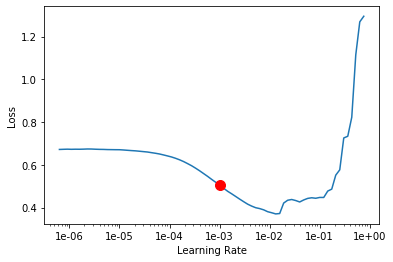

In [33]:
df = read_train_val_indices(
    cv_indices_dir / "0" / "train.txt",
    cv_indices_dir / "0" / "val.txt",
)

data = ImageList\
    .from_df(df, image_root_dir)\
    .split_from_df()\
    .label_from_df()\
    .transform(tfms, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')\
    .databunch(bs=batch_size, num_workers=4) \
    .normalize(imagenet_stats)

# learn = cnn_learner(data, models.resnet50, metrics=accuracy)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
learn = Learner(data, model, metrics=accuracy, path="/tmp/fastai-models")
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Start Training


| Backbone | Batchsize | resize/pad | epochs | max_lr | transform | accuracy | mean(accuracy) |
|-------|-------|-------|-------|-------|-------|-------|-------|
| b0 | 64 | resize | 1 | 1e-3 | max_rotate=15 | 0.990958, 0.969259, 0.971067, 0.975566, 0.961086 | 0.9735872 |
| b0 | 96 | resize | 1 | 1e-3 | max_rotate=15 | 0.978300, 0.949367, 0.971067, 0.973756, 0.961991 | 0.9668962 |
| b0 | 96 | resize | 1 | 2e-3 | max_rotate=15 | 0.980108, 0.973779, 0.960217, 0.969231, 0.987330 | 0.974133  |
| b0 | 96 | resize | 2 | 1e-3 | max_rotate=15 | 0.980108, 0.974684, 0.965642, 0.980995, 0.980995 | 0.9764848 |
| b0 | 96 | resize | 3 | 1e-3 | max_rotate=15 | 0.978300, 0.981917, 0.978300, 0.984615, 0.977376 | 0.9801016 |
| b0 | 96 |  pad   | 3 | 1e-3 | max_rotate=15 | 0.990054, 0.990054, 0.981013, 0.977376, 0.990950 | 0.9858894 |
| b0 | 96 |  pad   | 3 | 9e-4 | max_rotate=15 | 0.992767, 0.990958, 0.977396, 0.983710, 0.990950 | 0.987156  |
| b0 | 96 |  pad   | 3 | 9e-4 | max_rotate=10 |  |   |
| b0 | 96 | resize | 4 | 1e-3 | max_rotate=15 | 0.992767, 0.986438, 0.980108, 0.979186, 0.988235 | 0.9853468 |
| b0 | 96 |  pad   | 4 | 1e-3 | max_rotate=15 | 0.990958, 0.996383, 0.970163, 0.953846, 0.987330 | 0.979736  |
| b0 | 96 |  pad   | 4 | 8e-4 | max_rotate=15 | 0.990054, 0.995479, 0.981917, 0.966516, 0.979186 | 0.9826304 |
| b0 | 96 | resize | 5 | 1e-3 | max_rotate=15 | 0.987342, 0.988246, 0.981013, 0.986425, 0.989140 | 0.9864332 |
| b0 | 96 | resize | 2 | 2e-3 | max_rotate=15 | 0.981917, 0.977396, 0.945750, 0.975566, 0.960181 | 0.968162  |
| b3 | 56 | resize | 1 | 1e-3 | max_rotate=15 | 0.985533, 0.979204, 0.977396, 0.979186, 0.987330 | 0.9817298 |



In [31]:
max_lr = 9e-4
for fold in range(num_folds):
    data_fold = read_train_val_indices(
        cv_indices_dir / str(fold) / "train.txt",
        cv_indices_dir / str(fold) / "val.txt",
    )
    
    data = ImageList\
        .from_df(data_fold, image_root_dir)\
        .split_from_df()\
        .label_from_df()\
        .transform(tfms, size=224, resize_method=ResizeMethod.PAD, padding_mode='zeros')\
        .databunch(bs=batch_size, num_workers=4) \
        .normalize(imagenet_stats)

#     learn = cnn_learner(data, models.resnet50, metrics=accuracy)
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
    learn = Learner(data, model, metrics=accuracy, path="/tmp/fastai-models")
    learn.fit_one_cycle(n_max_epochs, max_lr=max_lr)
    
    if tta:
        print(f"TTA accuracy: {accuracy(*learn.TTA(scale=1.0))}")

Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.184993,0.210764,0.977396,00:25
1,0.069526,0.104467,0.987342,00:26
2,0.031921,0.024332,0.992767,00:26


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.193899,0.268737,0.972875,00:26
1,0.082891,0.049714,0.987342,00:26
2,0.040163,0.035799,0.990958,00:27


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.170176,0.312526,0.977396,00:26
1,0.065124,0.178959,0.975588,00:27
2,0.028190,0.096639,0.977396,00:27


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.160755,0.130287,0.984615,00:27
1,0.061164,0.099647,0.979186,00:27
2,0.026949,0.051046,0.983710,00:27


Loaded pretrained weights for efficientnet-b0


epoch,train_loss,valid_loss,accuracy,time
0,0.171300,0.105696,0.980995,00:27
1,0.070072,0.059871,0.986425,00:27
2,0.032461,0.038202,0.990950,00:27


### Understand Errors

In [11]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [12]:
top_losses_index = interp.top_losses(k=50).indices.numpy()

In [13]:
print(f"preds: {preds[top_losses_index].argmax(dim=1)}")
print(f"   gt: {y[top_losses_index]}")

preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
   gt: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


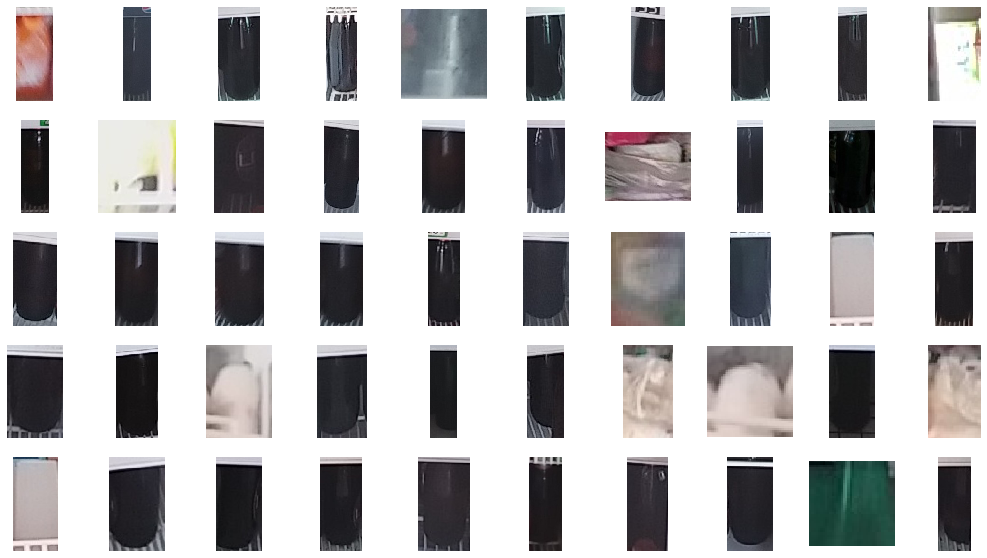

In [14]:
nrows, ncols = 5, 10
fig, ax = plt.subplots(5, 10, figsize=(18, 10))
for i, idx in enumerate(top_losses_index):
    data.valid_ds.x[idx].show(ax[i // ncols][i % ncols])

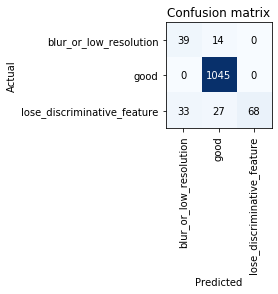

In [57]:
interp.plot_confusion_matrix()